In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [3]:
col_names = ["sentiment", "id", "date", "query", "user", "text"]
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", names=col_names, encoding="ISO-8859-1", on_bad_lines='skip')

df = df.head(10000)
df.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
def clean_text(t):
    if pd.isna(t): return ""
    t = re.sub(r"http\S+|www\S+", " ", t)
    t = re.sub(r"@\w+|#\w+", " ", t)
    t = re.sub(r"[^A-Za-z\s]", " ", t)
    return re.sub(r"\s+", " ", t).strip().lower()

df["clean_text"] = df["text"].apply(clean_text)

In [5]:
vect = TfidfVectorizer(stop_words="english", max_features=10000)
X = vect.fit_transform(df["clean_text"])

In [6]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X)

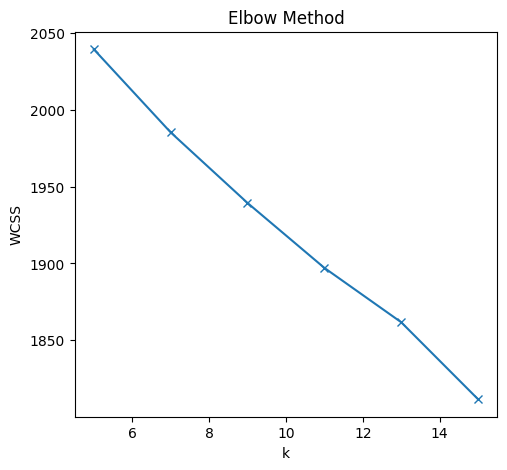

Best k: 5


In [7]:
k_num = list(range(5, 16, 2))
wcss= []
score = []

for k in k_num:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_reduced)
    wcss.append(km.inertia_)
    score.append(silhouette_score(X_reduced, labels))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_num, wcss, marker="x")
plt.title("Elbow Method")
plt.xlabel("k"), plt.ylabel("WCSS")

plt.show()

best_k = k_num[score.index(max(score))]
print("Best k:", best_k)

In [8]:
k_means = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = k_means.fit_predict(X_reduced)

sil_score = silhouette_score(X_reduced, labels)
print("Silhouette Score:", sil_score)
df["cluster"] = labels

Silhouette Score: 0.1266461055557681



Cluster 0 top words:
day         125.978534
today        15.905869
long         13.885309
work         12.711743
tomorrow     10.655170
going        10.280140
good          7.663570
bad           7.461126
having        7.179227
just          7.143936
sad           6.853538
bed           6.820003
Name: 0, dtype: float64


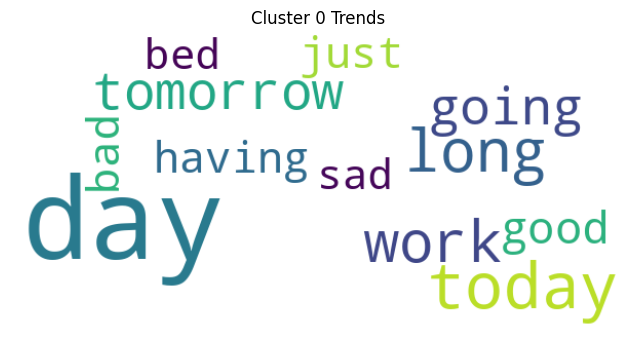


Cluster 1 top words:
just      146.056757
like      100.518272
today     100.483608
don        96.196896
really     86.344791
want       84.279868
going      83.997181
sad        83.524401
sorry      81.005562
got        79.901184
know       79.593643
sleep      79.493047
Name: 1, dtype: float64


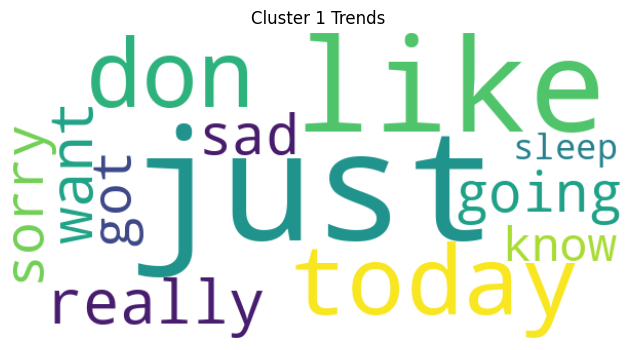


Cluster 2 top words:
cold       59.970506
really      3.445432
outside     2.911579
got         2.510844
spring      2.501255
today       2.484076
hate        2.294280
tired       2.218440
way         2.174463
working     2.042202
like        1.855183
bad         1.837967
Name: 2, dtype: float64


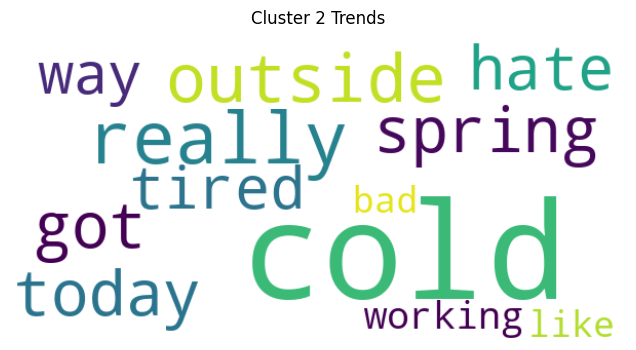


Cluster 3 top words:
work        179.754102
going        13.769789
home         11.344692
today        11.214872
bed          10.103179
ready         9.782203
tomorrow      9.078478
time          8.842348
early         8.425267
sleep         7.958066
wish          7.816476
sick          7.641462
Name: 3, dtype: float64


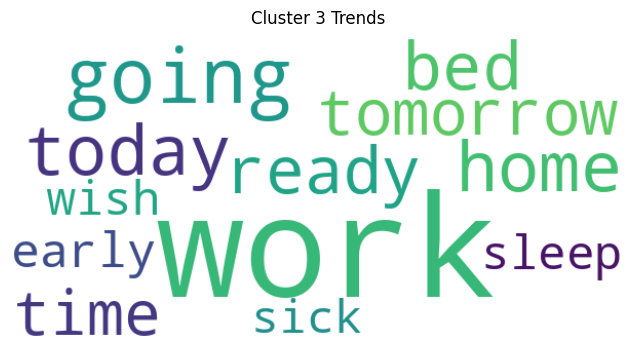


Cluster 4 top words:
morning    73.727049
good       14.347754
work        6.984327
day         4.953792
early       4.937980
today       4.421467
sleep       4.182974
woke        3.882233
cold        3.461826
snow        3.436603
quot        3.047155
oh          3.028065
Name: 4, dtype: float64


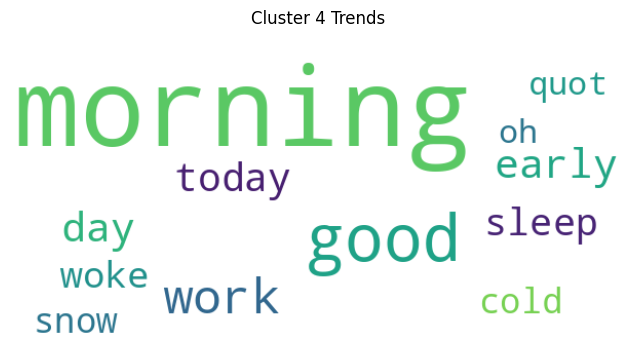

In [9]:
df_top_words = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
df_top_words["cluster"] = labels

cluster_word_sum = df_top_words.groupby("cluster").sum()

for c in sorted(cluster_word_sum.index):
    print(f"\nCluster {c} top words:")
    top = cluster_word_sum.loc[c].sort_values(ascending=False).head(12)
    print(top)

    wc = WordCloud(width=600, height=300, background_color="white")
    wc.generate_from_frequencies(top.to_dict())

    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {c} Trends")
    plt.show()

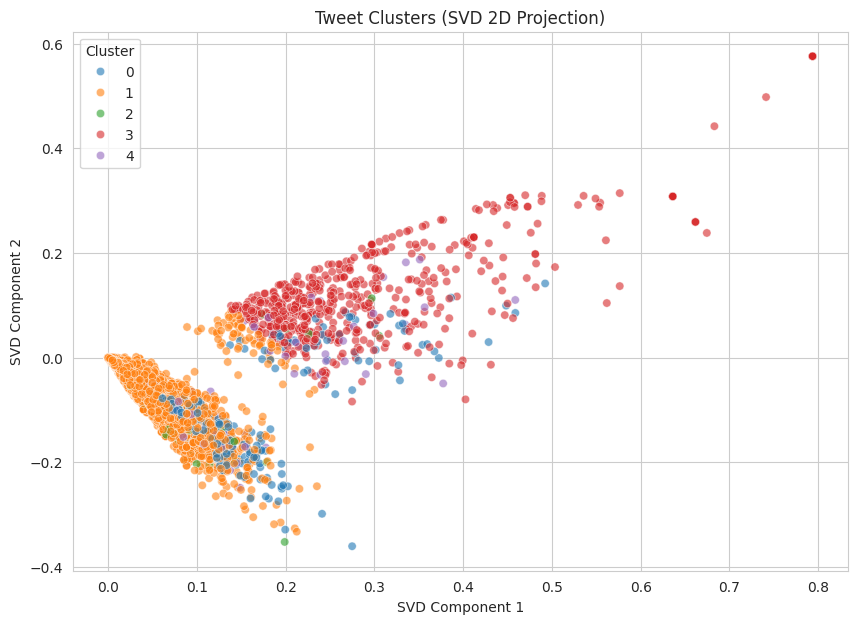

In [20]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=labels,
                palette="tab10", legend="full", alpha=0.6)
plt.title("Tweet Scatterplot")
plt.xlabel("C1")
plt.ylabel("C2")
plt.legend(title="Cluster")
plt.show()